# Dimension Reduction on Gated Populations

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joypy
import pacmap
import fitsne
import umap  # this is umap-learn
import flowkit as fk

%matplotlib inline

In [2]:
def make_plots(data, sample_ids, titles, marker, k=10000, seed=123):
    """Reduce scatter and fluorescent channel data to 2D for visualization."""

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    umap_reducer = umap.UMAP()
    pacmap_reducer = pacmap.PaCMAP()

    X_fitsne = fitsne.FItSNE(data_scaled)
    X_umap = umap_reducer.fit_transform(data_scaled)
    X_pacmap = pacmap_reducer.fit_transform(data_scaled)
    
    min_max_scaler = MinMaxScaler()
    X_reduceds = [
        min_max_scaler.fit_transform(tmp_x) for tmp_x in [X_fitsne, X_umap, X_pacmap]
    ]
    
    n = len(X_reduceds)
    fig, axes = plt.subplots(n, 3, figsize=(n*3, 9))

    for i, (X_reduced, title) in enumerate(zip(X_reduceds, titles)):
        for j in range(3):
            z = X[marker].iloc[(j*k):(j+1)*k]
            ax = axes[j, i]
            ax.scatter(
                X_reduced[(j*k):(j+1)*k, 0], 
                X_reduced[(j*k):(j+1)*k, 1], 
                s=1, 
                c=z, 
                cmap='jet'
            )
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim([-0.1,1.1])
            ax.set_ylim([-0.1,1.1])
            
            if j==0:
                ax.set_title(title, fontsize=14)
            if i==0:
                ax.set_ylabel('-'.join(sample_ids[j].split('_')[3:5]), fontsize=14)
    
    plt.tight_layout()

In [3]:
base_dir = "../../../data/8_color_data_set"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

In [4]:
workspace = fk.Workspace(wsp_path, fcs_samples=sample_path)

In [5]:
sample_groups = workspace.get_sample_groups()
sample_groups

['All Samples', 'DEN', 'GEN', 'G69', 'Lyo Cells']

In [6]:
sample_group = 'DEN'

In [7]:
sample_ids = sorted(workspace.get_sample_ids(sample_group))
sample_ids

['101_DEN084Y5_15_E01_008_clean.fcs',
 '101_DEN084Y5_15_E03_009_clean.fcs',
 '101_DEN084Y5_15_E05_010_clean.fcs']

In [8]:
print(workspace.get_gate_hierarchy(sample_ids[0], output='ascii'))

root
╰── Time
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3+
                ├── CD4+
                │   ├── CD107a+
                │   ├── IFNg+
                │   ├── IL2+
                │   ╰── TNFa+
                ╰── CD8+
                    ├── CD107a+
                    ├── IFNg+
                    ├── IL2+
                    ╰── TNFa+


In [9]:
workspace.analyze_samples(sample_group)

## Compare marker distributions between CD4+ and CD8+

In [10]:
k = 10_000
dfs_cd4 = []
dfs_cd8 = []

for sample_id in sample_ids:
    df_cd4 = workspace.get_gate_events(sample_id, gate_name='CD4+')
    df_cd8 = workspace.get_gate_events(sample_id, gate_name='CD8+')
    
    dfs_cd4.append(df_cd4)
    dfs_cd8.append(df_cd8)

X_cd4 = pd.melt(pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs_cd4]))
X_cd8 = pd.melt(pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs_cd8]))

X = pd.concat([X_cd4, X_cd8], axis=1)
X = X.iloc[:, [0,1,3]]
X.columns = ['marker', 'CD4+', 'CD8+']

In [11]:
X

,marker,CD4+,CD8+
0,FSC-H,0.490757,0.349461
1,FSC-H,0.467590,0.531681
2,FSC-H,0.403915,0.502178
3,FSC-H,0.315098,0.387924
4,FSC-H,0.397003,0.323277
...,...,...,...
389995,CD4 PE-Cy7 FLR-A,0.569951,0.365950
389996,CD4 PE-Cy7 FLR-A,0.588213,0.334475
389997,CD4 PE-Cy7 FLR-A,0.625763,0.338403
389998,CD4 PE-Cy7 FLR-A,0.569379,0.272289


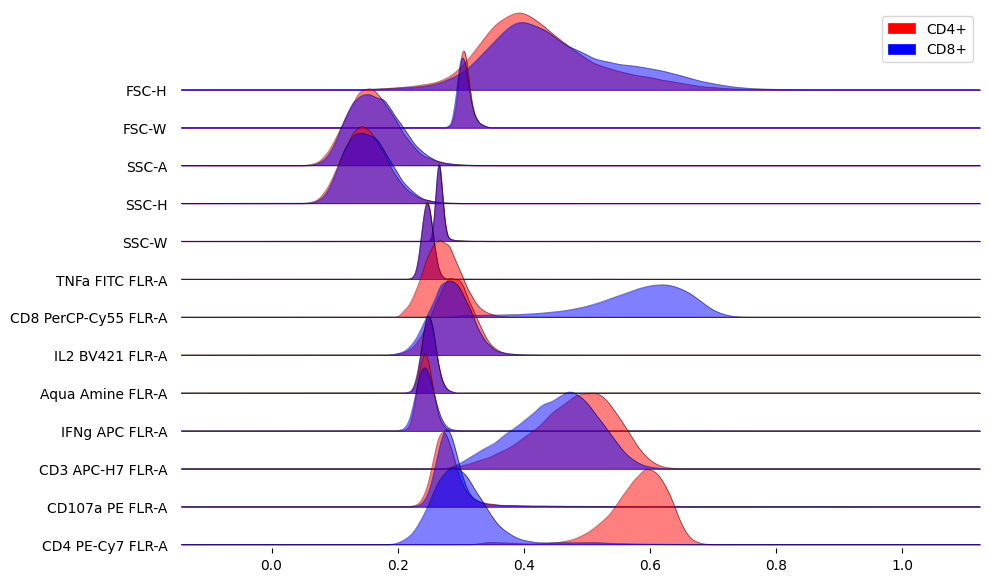

In [12]:
fig, ax = joypy.joyplot(
    X.groupby('marker', sort=False), 
    column=['CD4+', 'CD8+'],
    color=['red', 'blue'],
    legend=True,
    alpha=0.5,
    linewidth=0.5,
    ylim='own',
    figsize=(10, 6)
)

## Visualize dimension reduction schemes for events in Singlet gate

Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using ANNOY for knn search, with parameters: n_trees 50 and search_k 4500
Going to allocate memory. N: 30000, K: 90, N*K = 2700000
Building Annoy tree...
Done building tree. Beginning nearest neighbor search... 
parallel (20 threads):


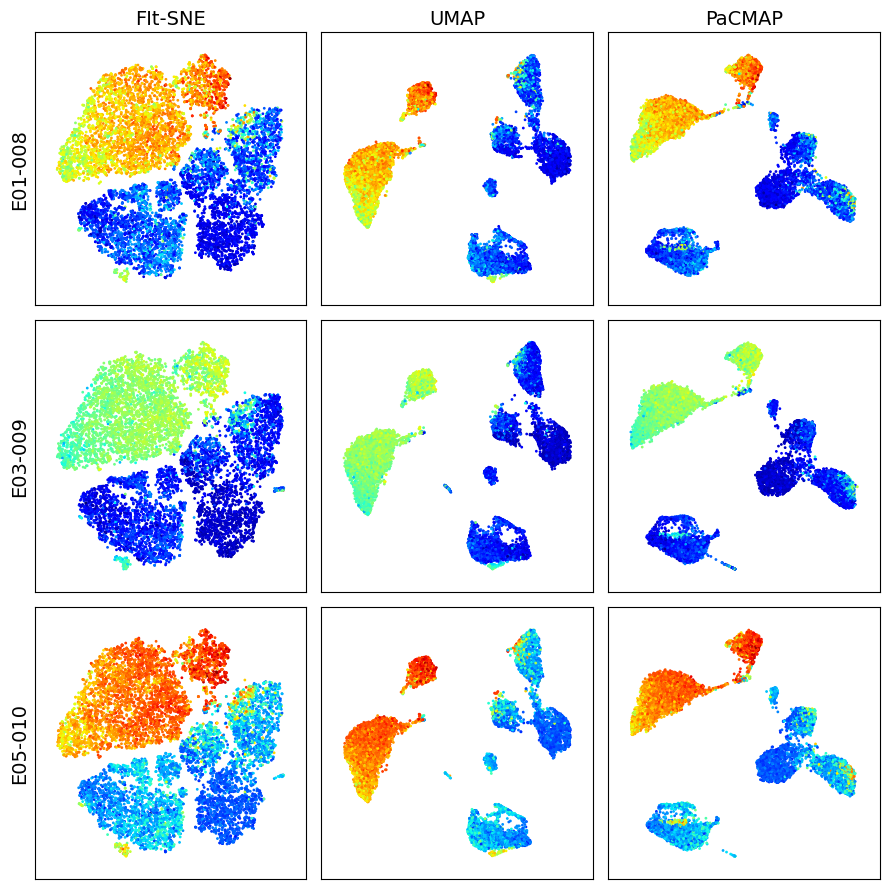

In [13]:
k = 10_000
dfs = []

for s_id in sample_ids:
    df = workspace.get_gate_events(s_id, gate_name='Singlets')
    dfs.append(df)

X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

marker = 'CD4 PE-Cy7 FLR-A'
titles = ['FIt-SNE', 'UMAP', 'PaCMAP']
make_plots(X, sample_ids, titles, marker, k)

## Visualize dimension reduction schemes for events in CD3+ gate


Symmetrizing...
Using the given initialization.
Exaggerating Ps by 12.000000
Input similarities computed (sparsity = 0.004300)!
Learning embedding...
Using FIt-SNE approximation.
Iteration 50 (50 iterations in 0.35 seconds), cost 5.320198
Iteration 100 (50 iterations in 0.35 seconds), cost 4.883578
Iteration 150 (50 iterations in 0.34 seconds), cost 4.770300
Iteration 200 (50 iterations in 0.34 seconds), cost 4.725874
Iteration 250 (50 iterations in 0.34 seconds), cost 4.696723
Unexaggerating Ps by 12.000000
Iteration 300 (50 iterations in 0.35 seconds), cost 3.564763
Iteration 350 (50 iterations in 0.36 seconds), cost 3.136181
Iteration 400 (50 iterations in 0.41 seconds), cost 2.919691
Iteration 450 (50 iterations in 0.56 seconds), cost 2.762066
Iteration 500 (50 iterations in 0.94 seconds), cost 2.667958
Iteration 550 (50 iterations in 0.91 seconds), cost 2.587644
Iteration 600 (50 iterations in 1.22 seconds), cost 2.532211
Iteration 650 (50 iterations in 1.41 seconds), cost 2.4908

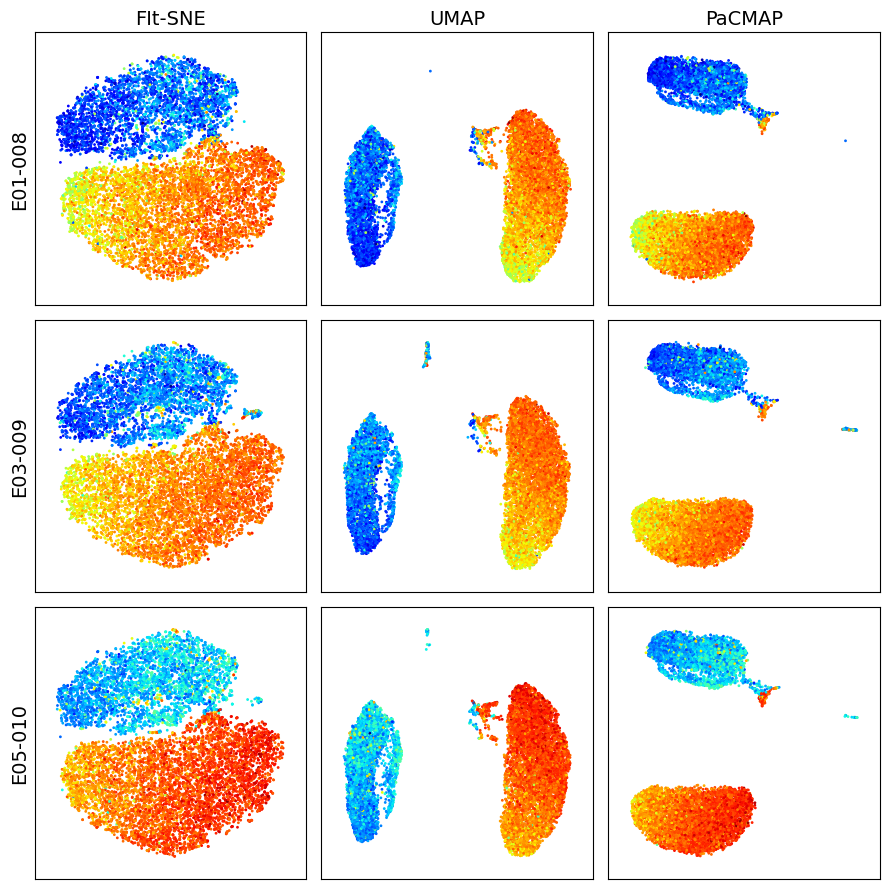

In [14]:
k = 10_000
dfs = []

for s_id in sample_ids:
    df = workspace.get_gate_events(s_id, gate_name='CD3+')
    dfs.append(df)

X = pd.concat([df.iloc[:, 2:-1].sample(k) for df in dfs])

marker = 'CD4 PE-Cy7 FLR-A'
titles = ['FIt-SNE', 'UMAP', 'PaCMAP']
make_plots(X, sample_ids, titles, marker, k)